### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempHybridSelectionMoreData/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 173 ms, sys: 136 ms, total: 309 ms
Wall time: 328 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 0
grace = 0 # if grace is setted aftere is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.8 s, sys: 62.1 ms, total: 13.8 s
Wall time: 13.8 s


In [12]:
survTr

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
0     2602482  21  0      0     0.0     0.0        0               81   
1     2603072  16  0      0     0.0     0.0        1               82   
2     2606370   7  0      0     0.0     0.0        1               82   
3     2608221   1  1      0     0.0     0.0        0               81   
4     2619378   1  1      0     0.0     0.0        1               78   
...       ...  .. ..    ...     ...     ...      ...              ...   
1586  5045131   1  1      0     0.0     0.0        0               63   
1587  5047030   1  1      0     0.0     0.0        0               59   
1588  5048711   4  0      0     0.0     0.0        0               22   
1589  5051413   1  0      0     0.0     1.0        1               26   
1590  5051718   4  0      0     0.0     0.0        0               34   

      ALLOW_AMT  ALLOW_ER  ...  ER_C  IP_BIN  IP_BIN2  IP_BIN6  IP_C  \
0      0.000000       0.0  ...     0       0      0.0      0.0     0   
1      4.615121       0.0  ...     1       0      0.0      0.0     0   
2      3.135494       0.0  ...     0       0      0.0      0.0     1   
3      6.091310       0.0  ...     0       0      0.0      0.0     0   
4      5.988961       0.0  ...     1       0      0.0      0.0     0   
...         ...       ...  ...   ...     ...      ...      ...   ...   
1586   8.196437       0.0  ...     0       0      0.0      0.0     0   
1587   7.617760       0.0  ...     0       0      0.0      0.0     0   
1588   0.000000       0.0  ...     0       0      0.0      0.0     0   
1589   4.382027       0.0  ...     1       0      0.0      0.0     0   
1590   5.697093       0.0  ...     0       0      0.0      0.0     0   

      MBR_GNDR  MEDICAID_LOB     MYR  PREGNANCY  Treatment  
0            0             1  201908        0.0          1  
1            0             1  202001        0.0          1  
2            0             1  202010        0.0          1  
3            0             1  202010        0.0          1  
4            1             1  201910        0.0          1  
...        ...           ...     ...        ...        ...  
1586         1             1  202012        0.0          1  
1587         0             1  202009        0.0          1  
1588         0             1  202101        0.0          1  
1589         0             1  202101        0.0          1  
1590         0             1  202101        0.0          1  

[1591 rows x 92 columns]

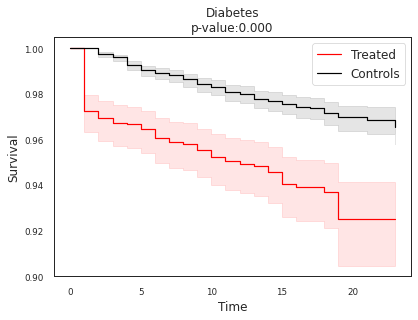

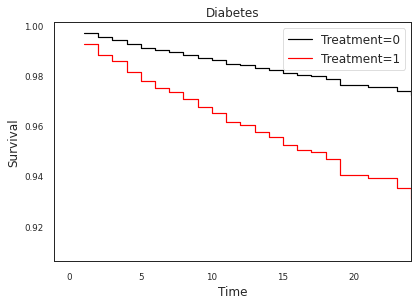

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       51.003722  9.219099e-13  39.980439

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  1.882           0.391        4.818    0.000
Gender               0.316           0.136        2.325    0.020
Total Cost           0.257           0.100        2.566    0.010
Tobacco use         -0.196           0.228       -0.861    0.389
Obesity              0.300           0.141        2.132    0.033
Hypertension        -0.023           0.152       -0.151    0.880
Hypothyroid         -0.210           0.235       -0.890    0.373
Disease Count        1.332           0.627        2.123    0.034
Treatment            0.935           0.138        6.759    0.000

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.9 s, sys: 31.5 ms, total: 14 s
Wall time: 14 s


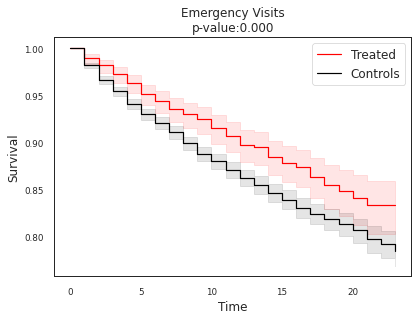

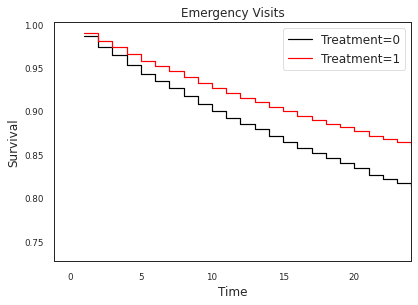

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [19]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits       13.014478  0.000309  11.659676

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.059           0.167      -12.307    0.000
Gender              -0.168           0.065       -2.598    0.009
Total Cost           0.224           0.044        5.105    0.000
Tobacco use          0.508           0.078        6.503    0.000
Obesity             -0.031           0.065       -0.475    0.635
Hypertension         0.233           0.073        3.175    0.001
Hypothyroid         -0.137           0.108       -1.271    0.204
Disease Count        2.202           0.285        7.718    0.000
Treatment           -0.322           0.084       -3.823    0.000

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 14 s, sys: 32 ms, total: 14 s
Wall time: 14 s


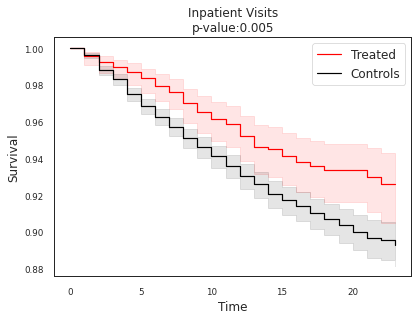

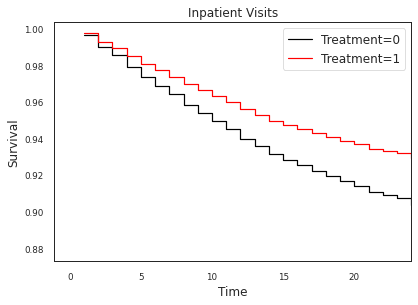

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [24]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits        7.857656  0.005061  7.626477

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.687           0.238       -7.097    0.000
Gender              -0.114           0.091       -1.243    0.214
Total Cost           0.309           0.067        4.623    0.000
Tobacco use          0.434           0.110        3.942    0.000
Obesity             -0.194           0.093       -2.082    0.037
Hypertension         0.178           0.103        1.733    0.083
Hypothyroid          0.048           0.141        0.336    0.737
Disease Count        2.579           0.394        6.545    0.000
Treatment           -0.320           0.122       -2.635    0.008

### Acute Care IP OR ER

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 13.7 s, sys: 39.7 ms, total: 13.8 s
Wall time: 13.7 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
4     2619378   3  1      0     0.0     0.0        1               78   
5     2621187  11  1      0     0.0     0.0        2               78   
17    2651688   4  1      0     0.0     0.0        0               74   
28    2668219   5  1      0     0.0     0.0        0               71   
31    2674753   3  1      0     0.0     0.0        0               71   
...       ...  .. ..    ...     ...     ...      ...              ...   
1536  5003200   1  1      1     1.0     1.0        1               55   
1545  5010677  16  1      0     0.0     0.0        0               39   
1550  5014675   3  1      0     0.0     0.0        1               26   
1563  5021778   1  1      1     1.0     1.0        1               24   
1574  5028397   2  1      0     0.0     0.0        0               39   

      ALLOW_AMT  ALLOW_ER  ...  ER_C  IP_BIN  IP_BIN2  IP_BIN6  IP_C  \
4      5.988961  0.000000  ...     1       0      0.0      0.0     0   
5      9.473243  0.000000  ...     2       0      0.0      0.0     0   
17     5.187386  0.000000  ...     0       0      0.0      0.0     0   
28     5.846439  0.000000  ...     0       0      0.0      0.0     0   
31     5.332719  0.000000  ...     0       0      0.0      0.0     0   
...         ...       ...  ...   ...     ...      ...      ...   ...   
1536   8.051022  7.168580  ...     1       0      0.0      0.0     0   
1545   0.000000  0.000000  ...     0       0      0.0      0.0     0   
1550   6.013715  0.000000  ...     1       0      0.0      0.0     0   
1563   9.921082  7.057037  ...     1       0      0.0      0.0     0   
1574   0.000000  0.000000  ...     0       0      0.0      0.0     0   

      MBR_GNDR  MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4            1             1  201910        0.0          1  
5            1             1  202001        0.0          1  
17           1             1  202011        0.0          1  
28           0             1  201911        0.0          1  
31           0             1  202004        0.0          1  
...        ...           ...     ...        ...        ...  
1536         0             1  202005        0.0          1  
1545         0             1  202001        0.0          1  
1550         0             1  202010        0.0          1  
1563         0             1  202007        0.0          1  
1574         0             1  202005        0.0          1  

[220 rows x 93 columns]

In [29]:
treated[treated.PERS_ID == '4386027'][['IP_BIN','ER_BIN']]

Empty DataFrame
Columns: [IP_BIN, ER_BIN]
Index: []

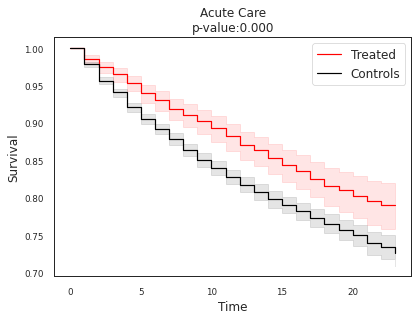

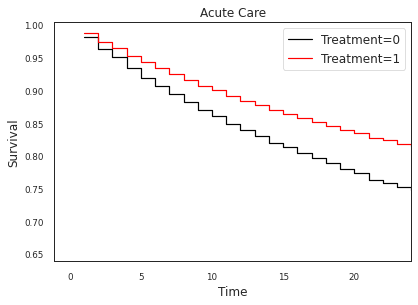

In [30]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [31]:
lrsumm

test_statistic        p   -log2(p)
Acute Care       19.555318  0.00001  16.642792

In [32]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.847           0.147      -12.528    0.000
Gender              -0.173           0.057       -3.054    0.002
Total Cost           0.260           0.039        6.624    0.000
Tobacco use          0.417           0.070        5.948    0.000
Obesity             -0.079           0.057       -1.380    0.168
Hypertension         0.199           0.064        3.092    0.002
Hypothyroid         -0.071           0.092       -0.768    0.442
Disease Count        2.382           0.254        9.376    0.000
Treatment           -0.352           0.074       -4.728    0.000

### Load all Log Rank Sums in a matrix

In [33]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [34]:
df2

logRank statistic   p-value  RMST difference
Diabetes                1734.829937  0.000000        -0.761261
Emergency Visits          13.014478  0.000309         0.735700
Inpatient Vistis           7.857656  0.005061         0.483160
Acute Care                19.555318  0.000010         1.058033